# Gradient Descent

Download the Data Science from Scratch repository into the folder `dsfs`.

In [18]:
import os

if not os.path.isdir('dsfs'):
    !git clone --depth 1 https://github.com/joelgrus/data-science-from-scratch dsfs

Import the needed functions.

In [19]:
from dsfs.scratch.linear_algebra import Vector, dot, distance, add, scalar_multiply, vector_mean

## The Idea Behind Gradient Descent

In [20]:
def sum_of_squares(v: Vector) -> float:
    """Computes the sum of squared elements in v"""
    return dot(v, v)

## Estimating the Gradient

In [21]:
from typing import Callable

def difference_quotient(f: Callable[[float], float],
                        x: float,
                        h: float) -> float:
    return (f(x + h) - f(x)) / h

In [22]:
def square(x: float) -> float:
    return x * x

def derivative(x: float) -> float:
    return 2 * x

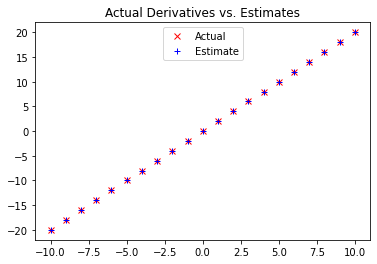

In [23]:
xs = range(-10, 11)
actuals = [derivative(x) for x in xs]
estimates = [difference_quotient(square, x, h=0.001) for x in xs]

# plot to show they're basically the same
import matplotlib.pyplot as plt
plt.title("Actual Derivatives vs. Estimates")
plt.plot(xs, actuals, 'rx', label='Actual')       # red  x
plt.plot(xs, estimates, 'b+', label='Estimate')   # blue +
plt.legend(loc=9)
plt.show()

In [24]:
def partial_difference_quotient(f: Callable[[Vector], float],
                                    v: Vector,
                                    i: int,
                                    h: float) -> float:
    """Returns the i-th partial difference quotient of f at v"""
    w = [v_j + (h if j == i else 0)    # add h to just the ith element of v
            for j, v_j in enumerate(v)]

    return (f(w) - f(v)) / h

In [25]:
def estimate_gradient(f: Callable[[Vector], float],
                      v: Vector,
                      h: float = 0.0001):
    return [partial_difference_quotient(f, v, i, h)
            for i in range(len(v))]

In [26]:
# f(x, y) = x^2 + y^2
# fx'(x, y) = 2x
# fy'(x, y) = 2y

estimate_gradient(lambda vector: vector[0] ** 2 + vector[1] ** 2, [2, 1])

[4.0001000000078335, 2.000100000003613]

## Using the Gradient

In [27]:
import random

def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def sum_of_squares_gradient(v: Vector) -> Vector:
    return [2 * v_i for v_i in v]

In [28]:
# pick a random starting point
v = [random.uniform(-10, 10) for i in range(3)]

for epoch in range(1000):
    grad = sum_of_squares_gradient(v)    # compute the gradient at v
    v = gradient_step(v, grad, -0.01)    # take a negative gradient step
    if epoch % 100 == 0:                 # print every 100 epochs
        print(epoch, v)

0 [-2.2521191009629953, -0.8271312144159854, -3.8043117507360216]
100 [-0.29867503499180315, -0.10969377432253591, -0.5045261348678024]
200 [-0.039610150497462804, -0.014547539635073988, -0.06691003194346434]
300 [-0.005253080567897856, -0.0019292882457648325, -0.008873578721245994]
400 [-0.0006966612119939712, -0.0002558613503462995, -0.0011768100692087756]
500 [-9.239090054374097e-05, -3.393221865355813e-05, -0.00015606802875094144]
600 [-1.225284019882724e-05, -4.500075768358537e-06, -2.0697672662319426e-05]
700 [-1.6249662256178467e-06, -5.967980498924495e-07, -2.7449161565317765e-06]
800 [-2.1550229918541214e-07, -7.914709233559137e-08, -3.64029561647577e-07]
900 [-2.8579819212267575e-08, -1.049645223590715e-08, -4.827743879826332e-08]


In [29]:
distance(v, [0, 0, 0]) < 0.001    # v should be close to 0

True

## Using Gradient Descent to Fit Models

In [30]:
# x ranges from -50 to 49, y is always 20 * x + 5
inputs = [(x, 20 * x + 5) for x in range(-50, 50)]

def linear_gradient(x: float, y: float, theta: Vector) -> Vector:
    slope, intercept = theta
    predicted = slope * x + intercept    # The prediction of the model.
    error = (predicted - y)              # error is (predicted - actual)
    squared_error = error ** 2           # We'll minimize squared error
    grad = [2 * error * x, 2 * error]    # using its gradient.
    return grad

In [31]:
# Start with random values for slope and intercept.
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

learning_rate = 0.001

for epoch in range(5000):
    # Compute the mean of the gradients
    grad = vector_mean([linear_gradient(x, y, theta) for x, y in inputs])
    # Take a step in that direction
    theta = gradient_step(theta, grad, -learning_rate)
    if epoch % 1000 == 0:
        print(epoch, theta)

slope, intercept = theta
assert 19.9 < slope < 20.1,   "slope should be about 20"
assert 4.9 < intercept < 5.1, "intercept should be about 5"

0 [33.66356019423278, -0.174670657030819]
1000 [19.99958064528482, 4.301774147360938]
2000 [19.999943325959265, 4.905637688138569]
3000 [19.99999234073977, 4.987247327113169]
4000 [19.999998964882924, 4.99827652944751]


## Minibatch and Stochastic Gradient Descent

In [32]:
from typing import TypeVar, List, Iterator

T = TypeVar('T')  # this allows us to type "generic" functions

def minibatches(dataset: List[T],
                batch_size: int,
                shuffle: bool = True) -> Iterator[List[T]]:
    """Generates `batch_size`-sized minibatches from the dataset"""
    # Start indexes 0, batch_size, 2 * batch_size, ...
    batch_starts = [start for start in range(0, len(dataset), batch_size)]

    if shuffle: random.shuffle(batch_starts)  # shuffle the batches

    for start in batch_starts:
        end = start + batch_size
        yield dataset[start:end]

In [33]:
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

for epoch in range(1000):
    for batch in minibatches(inputs, batch_size=20):
        grad = vector_mean([linear_gradient(x, y, theta) for x, y in batch])
        theta = gradient_step(theta, grad, -learning_rate)
    if epoch % 100 == 0:
        print(epoch, theta)

slope, intercept = theta
assert 19.9 < slope < 20.1,   "slope should be about 20"
assert 4.9 < intercept < 5.1, "intercept should be about 5"

0 [19.174202715078767, 1.079209387747482]
100 [20.267395842970828, 4.330392766687993]
200 [19.992748148789925, 4.826898806075673]
300 [20.000014117407332, 4.960295982979091]
400 [20.001111219955906, 4.99325906073336]
500 [20.00000750566774, 4.997630902238474]
600 [20.000001793957406, 4.999567727602932]
700 [19.99999533067239, 4.99986955748152]
800 [19.9999899808177, 4.9999576506544825]
900 [20.00000033989906, 4.999992824479073]


In [34]:
# Stochastic gradient descent example
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

for epoch in range(100):
    for x, y in inputs:
        grad = linear_gradient(x, y, theta)
        theta = gradient_step(theta, grad, -learning_rate)
    if epoch % 10 == 0:
        print(epoch, theta)

slope, intercept = theta
assert 19.9 < slope < 20.1,   "slope should be about 20"
assert 4.9 < intercept < 5.1, "intercept should be about 5"

0 [20.091422139670822, 0.44973150232344167]
10 [20.0589663750914, 2.0651013388512043]
20 [20.03803298265049, 3.1070061736705443]
30 [20.024531058911496, 3.779029178507888]
40 [20.015822394846502, 4.212480396644925]
50 [20.010205352819014, 4.492054097774306]
60 [20.006582420397063, 4.672377629459557]
70 [20.00424561322211, 4.788685337413492]
80 [20.002738406799633, 4.8637031816411636]
90 [20.001766253782453, 4.91208928670809]
